# **A Deep Dive into Why GPUs Outpace CPUs**  A Hands-On Tutorial

FLOPS is commonly used to quantify the computational power of processors and other computing devices. It is an important metric for tasks that involve complex mathematical calculations, such as scientific simulations, artificial intelligence and machine learning algorithms. <p>

FLOPS stands for "Floating Point Operations Per Second" which means the number of floating-point calculations a computer system can perform in one second. The higher the FLOPS value, the faster the computer or processor can perform floating-point calculations, indicating better computational performance.
<p>
In this tutorial, let us use FLOPS as a metric to evaluate the performance of CPU versus GPU. We will begin by employing the DAXPY (Double-precision A*X plus Y) operation, a commonly used operation in numerical computing. This operation involves multiplying a scalar (A) with a vector (X) and adding the result to another vector (Y). We will calculate FLOPS to perform the DAXPY operation using both the CPU and GPU, respectively.
<p>
The DAXPY operation is executed using NumPy operations (A * X + Y). NumPy can leverage optimized implementations, and the actual computation may occur in optimized C or Fortran libraries. Therefore, a more effective way to compare speeds is by conducting matrix multiplications using TensorFlow. The second part of our code is designed to accomplish precisely this task. We will perform matrix multiplications of various-sized matrices and explore how the true advantage of GPUs lies in working with large matrices (datasets in general).



**Let us start by finding out the details of our current hadrware.**

In [1]:
import psutil
import tensorflow as tf

# CPU Information
cpu_info = {
    "Physical Cores": psutil.cpu_count(logical=False),
    "Total Cores": psutil.cpu_count(logical=True),
    "CPU Frequency": psutil.cpu_freq().current,
    "CPU Usage": psutil.cpu_percent(interval=1),
}

print("CPU Information:")
for key, value in cpu_info.items():
    print(f"{key}: {value}")

# GPU Information
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    gpu_info = tf.config.experimental.get_device_details(physical_devices[0])
    print("\nGPU Information:")
    for key, value in gpu_info.items():
        print(f"{key}: {value}")
else:
    print("\nGPU not available on this machine.")


CPU Information:
Physical Cores: 1
Total Cores: 2
CPU Frequency: 2000.2
CPU Usage: 1.0

GPU Information:
compute_capability: (7, 5)
device_name: Tesla T4


At the time of this testing, the GPU offered by Colab is Tesla T4 <br><p>
**Specifications:** <br>
* Turing Tensor Cores. 320. <br>
* **NVIDIA CUDA cores. 2,560.** <br>
* **Single Precision Performance (FP32) 8.1 TFLOPS.**<br>
* Mixed Precision (FP16/FP32) 65 FP16 TFLOPS.<br>
* INT8 Precision. 130 INT8 TOPS.<br>
* INT4 Precision. 260 INT4 TOPS.<br>




**Calculating FLOPS for CPU and GPU using DAXPY**

In [2]:
import numpy as np
import time
import tensorflow as tf

def perform_daxpy(array_size, use_gpu=False):
    if use_gpu:
        device = '/device:GPU:0'
    else:
        device = '/device:CPU:0'

    with tf.device(device):
        # Create NumPy arrays for vectors X, Y, and a scalar A
        A = 2.0  # Scalar
        X = np.random.rand(array_size)
        Y = np.random.rand(array_size)

        # Measure the time taken for the DAXPY operation
        start_time = time.time()
        result = A * X + Y
        end_time = time.time()

        # Calculate FLOPS
        elapsed_time = end_time - start_time
        flops = array_size / elapsed_time

        return flops


# Define the size of the array for the operation
array_size = 10**6  #System crashes for large arrays as they may exceed system memory.

# Perform DAXPY on CPU
cpu_flops = perform_daxpy(array_size, use_gpu=False)
print(f"CPU FLOPS: {cpu_flops:.2e}")

# Perform DAXPY on GPU (if available)
if tf.config.experimental.list_physical_devices('GPU'):
    gpu_flops = perform_daxpy(array_size, use_gpu=True)
    print(f"GPU FLOPS: {gpu_flops:.2e}")
    # Calculate percent difference
    percent_difference = abs((gpu_flops - cpu_flops) / cpu_flops) * 100
    print(f"GPU is {percent_difference:.2f}% faster than CPU.")
else:
    print("GPU not available on this machine.")



CPU FLOPS: 1.32e+08
GPU FLOPS: 2.27e+08
GPU is 72.30% faster than CPU.


We do not see a significant advantage of GPU over CPU. This is because DAXPY is not a suitable operation for this test. Moreover, increasing the array_size for this test beyond 10**6 (at the time of this test) demands additional RAM and crashes the system. Therefore, let us continue our CPU vs GPU speed test using matrix multiplication with the TensorFlow library.

**Testing CPU vs GPU speed using matrix multiplication**

Here, we will verify the GPU speed advantage over CPU for different matrix sizes. The relative efficiency of the GPU compared to the CPU can vary based on the computational demands of the specific task. <p>
In order to make sure we start with a common base line for each matrix multiplication task, we will clear the default graph and release the GPU memory. We will also disable the eager execution in TensorFlow for the matrix multiplication task. Please note that eager execution is a mode that allows operations to be executed immediately as they are called, instead of requiring them to be explicitly executed within a session. Eager execution is enabled by default in TensorFlow 2.x. By disabling eager execution, operations are added to a computation graph, and the graph is executed within a session.

In [3]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

def perform_matmul(matrix_size, use_gpu=False):
    if use_gpu:
        device = '/device:GPU:0'
    else:
        device = '/device:CPU:0'

    with tf.device(device):
        # Reset default graph and clear GPU memory
        tf.compat.v1.reset_default_graph()

        # Create NumPy arrays for matrices A and B
        A = np.random.rand(matrix_size, matrix_size)
        B = np.random.rand(matrix_size, matrix_size)

        # Disable eager execution temporarily
        tf.config.experimental_run_functions_eagerly(False)

        # Measure the time taken for the matrix multiplication
        start_time = time.time()
        result = tf.matmul(A, B)
        end_time = time.time()

        # Enable eager execution again
        tf.config.experimental_run_functions_eagerly(True)

        # Calculate FLOPS
        elapsed_time = end_time - start_time
        flops = 2 * matrix_size**3 / elapsed_time

        # Convert FLOPS to TFLOPS
        tflops = flops / 1e12

        return tflops

# Matrix sizes to test
matrix_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
                5000, 7500, 10000]

# Lists to store results
data = {'Matrix Size': [], 'GPU TFLOPS': [], 'CPU TFLOPS': [], 'Percentage Speedup': []}

# Loop through matrix sizes
for matrix_size in matrix_sizes:
    tflops_gpu = perform_matmul(matrix_size, use_gpu=True)
    tflops_cpu = perform_matmul(matrix_size, use_gpu=False)

    # Calculate percentage speedup
    percentage_speedup = ((tflops_gpu - tflops_cpu) / tflops_cpu) * 100

    # Store data in the dictionary
    data['Matrix Size'].append(matrix_size)
    data['GPU TFLOPS'].append(tflops_gpu)
    data['CPU TFLOPS'].append(tflops_cpu)
    data['Percentage Speedup'].append(percentage_speedup)

    # Print results for each matrix size
    print(f"Matrix Size: {matrix_size}, GPU TFLOPS: {tflops_gpu}, CPU TFLOPS: {tflops_cpu}")
    print(f"GPU is {percentage_speedup:.2f}% faster than CPU.\n")

# Create a DataFrame from the collected data
df = pd.DataFrame(data)



Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Matrix Size: 100, GPU TFLOPS: 1.2498521979593783e-05, CPU TFLOPS: 0.0008660549246334916
GPU is -98.56% faster than CPU.

Matrix Size: 200, GPU TFLOPS: 0.00045963086448502115, CPU TFLOPS: 0.006537002142996299
GPU is -92.97% faster than CPU.

Matrix Size: 300, GPU TFLOPS: 0.020642764855997083, CPU TFLOPS: 0.01123195715348376
GPU is 83.79% faster than CPU.

Matrix Size: 400, GPU TFLOPS: 0.040275387246811706, CPU TFLOPS: 0.01179262206211835
GPU is 241.53% faster than CPU.

Matrix Size: 500, GPU TFLOPS: 0.09425402247191011, CPU TFLOPS: 0.015605899599648762
GPU is 503.96% faster than CPU.

Matrix Size: 600, GPU TFLOPS: 0.0661533161007667, CPU TFLOPS: 0.01559153733231222
GPU is 324.29% faster than CPU.

Matrix Size: 700, GPU TFLOPS: 0.13229539491470874, CPU TFLOPS: 0.01403687436396544
GPU is 842.48% faster than CPU.

Matrix Size: 800, GPU TFLOPS: 0.13196200251943344, CPU TFLOPS: 0.01586826211095676
GPU is 731.61% faster than CPU.

Matrix Size: 900, GPU TFLOPS: 0.12803951408052597, CPU TFLOPS:

How come CPU is faster than GPU for small matrix sizes? <br>
For small matrices, the computational advantage of the GPU may not outweigh the associated overhead and warm-up time. As the matrix size increases, the GPU's parallel processing capability becomes more effective

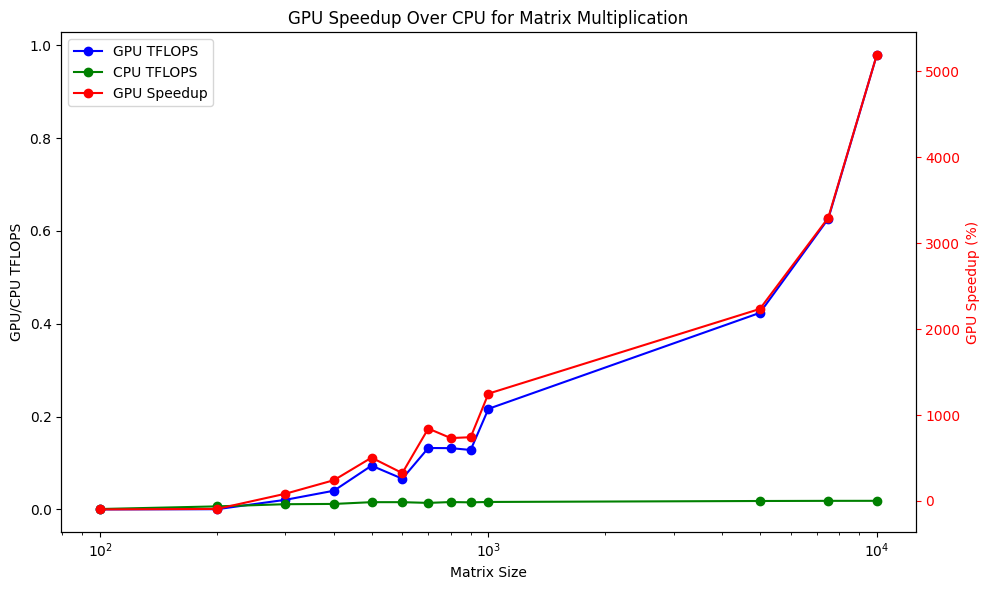

In [4]:
# Plotting the results with CPU and GPU TFLOPS, and Percentage Speedup
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GPU TFLOPS on the primary y-axis
gpu_tflops_line, = ax1.plot(df['Matrix Size'], df['GPU TFLOPS'], marker='o', linestyle='-', color='blue', label='GPU TFLOPS')
cpu_tflops_line, = ax1.plot(df['Matrix Size'], df['CPU TFLOPS'], marker='o', linestyle='-', color='green', label='CPU TFLOPS')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('GPU/CPU TFLOPS', color='black')
ax1.tick_params('y', colors='black')

# Create a secondary y-axis for Percentage Speedup
ax2 = ax1.twinx()
speedup_line, = ax2.plot(df['Matrix Size'], df['Percentage Speedup'], marker='o', linestyle='-', color='red', label='GPU Speedup')
ax2.set_ylabel('GPU Speedup (%)', color='red')
ax2.tick_params('y', colors='red')

# Add legend
lines = [gpu_tflops_line, cpu_tflops_line, speedup_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.title('GPU Speedup Over CPU for Matrix Multiplication')
fig.tight_layout()
plt.show()


**Summary of our experiment:**
 <p>
 GPU is highly effective in handling larger and more computationally intensive tasks. On the other hand, the CPU's performance appears to plateau with the matrix size.

### Write an code for the follwoing  

You are a data scientist working at a company that develops image recognition systems. Your team has been tasked with building an image classification model to recognize handwritten digits from the MNIST dataset. The goal is to build a model that can classify digits (0-9) accurately and efficiently. The model should be trained both on a CPU and a GPU to compare the performance and determine the best hardware setup for deployment in production. You decide to use a Convolutional Neural Network (CNN) architecture for this task, as it is known to perform well with image data.

The model architecture consists of several layers designed for image classification tasks, such as recognizing digits from the MNIST dataset. The architecture begins with a 2D convolutional layer (Conv2D), which applies 32 filters of size 3x3 to the input image (28x28x1), followed by the ReLU activation function to introduce non-linearity. This is followed by a max-pooling layer (MaxPooling2D) with a pool size of 2x2, reducing the spatial dimensions of the feature maps while retaining important information. A second convolutional layer with 64 filters of size 3x3 is then applied, again using ReLU activation. Another max-pooling layer  (2x2 ) follows to further downsample the feature maps. The output of the convolutional layers is then flattened into a one-dimensional vector using the Flatten layer, which is fed into the fully connected dense layers. The first dense layer has 64 neurons with ReLU activation, allowing the model to learn complex representations, while the final dense layer has 10 neurons with a softmax activation function, providing probabilities for each of the 10 possible digit classes.


The training process is measured on both CPU and GPU, and you are also tracking the time it takes to train the model on each device.

In [1]:
import tensorflow as tf
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to [0,1]

# Reshape data to fit CNN input format
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to train model and measure time
def train_model(device):
    with tf.device(device):
        model = create_model()
        start_time = time.time()
        model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), verbose=2)
        end_time = time.time()
    return model, end_time - start_time

# Train on CPU
print("Training on CPU...")
cpu_model, cpu_time = train_model('/CPU:0')
print(f"CPU training time: {cpu_time:.2f} seconds")

# Train on GPU if available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Training on GPU...")
    gpu_model, gpu_time = train_model('/GPU:0')
    print(f"GPU training time: {gpu_time:.2f} seconds")
else:
    print("No GPU found. Skipping GPU training.")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training on CPU...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
938/938 - 331s - 353ms/step - accuracy: 0.9451 - loss: 0.1827 - val_accuracy: 0.9836 - val_loss: 0.0540
Epoch 2/5
938/938 - 321s - 343ms/step - accuracy: 0.9840 - loss: 0.0514 - val_accuracy: 0.9881 - val_loss: 0.0343
Epoch 3/5
938/938 - 316s - 337ms/step - accuracy: 0.9885 - loss: 0.0366 - val_accuracy: 0.9880 - val_loss: 0.0356
Epoch 4/5
938/938 - 324s - 346ms/step - accuracy: 0.9910 - loss: 0.0282 - val_accuracy: 0.9893 - val_loss: 0.0315
Epoch 5/5
938/938 - 317s - 338ms/step - accuracy: 0.9930 - loss: 0.0215 - val_accuracy: 0.9920 - val_loss: 0.0269
CPU training time: 1615.53 seconds
Training on GPU...
Epoch 1/5
938/938 - 10s - 10ms/step - accuracy: 0.9448 - loss: 0.1824 - val_accuracy: 0.9753 - val_loss: 0.0745
Epoch 2/5
938/938 - 5s - 6ms/step - accuracy: 0.9823 - loss: 0.0548 - val_accuracy: 0.9849 - val_loss: 0.0482
Epoch 3/5
938/938 - 5s - 6ms/step - accuracy: 0.9877 - loss: 0.0390 - val_accuracy: 0.9888 - val_loss: 0.0336
Epoch 4/5
938/938 - 5s - 5ms/step - accuracy

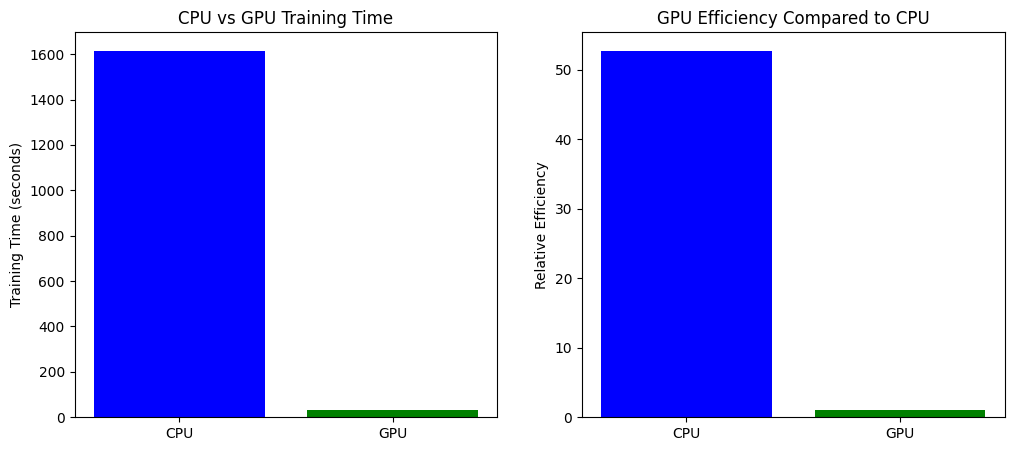

In [3]:
import matplotlib.pyplot as plt


if gpu_time:
    labels = ['CPU', 'GPU']
    times = [cpu_time, gpu_time]
    efficiency = [(cpu_time/gpu_time) if gpu_time else 0, 1]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].bar(labels, times, color=['blue', 'green'])
    axs[0].set_ylabel('Training Time (seconds)')
    axs[0].set_title('CPU vs GPU Training Time')

    axs[1].bar(labels, efficiency, color=['blue', 'green'])
    axs[1].set_ylabel('Relative Efficiency')
    axs[1].set_title('GPU Efficiency Compared to CPU')

    plt.show()
